# Qualitative Analysis of Generated Dialogues

Before we begin, let's make sure we have the environment all set up...

In [ ]:
# Setup the environment depending on weather we are running in Google Colab or Jupyter Notebook
from IPython import get_ipython

colab = False
if "google.colab" in str(get_ipython()):
    print("Running on CoLab")
    from PIL import Image
    colab = True

    # Downloading only the "output" directory from the repository
    !git init .
    !git remote add -f origin https://github.com/Play-Your-Part/tutorials.git
    !git config core.sparseCheckout true
    !echo "output" >> .git/info/sparse-checkout
    !git pull origin main

    # Installing Ollama
    !curl -fsSL https://ollama.com/install.sh | sh

    # Installing dependencies
    %pip install sdialog
    %pip install simpleneighbors

else:
    print("Running in Jupyter Notebook")
    # Little hack to avoid the "OSError: Background processes not supported." error in Jupyter notebooks"
    import os
    get_ipython().system = os.system

Let's make sure we have the STAR dataset downloaded inside the `datasets` folder:

In [ ]:
# Let's clone the STAR dataset repository
!git clone https://github.com/RasaHQ/STAR.git datasets/STAR

# Let's check that `dialogues` and `tasks` folders are inside `datasets/STAR`
!ls datasets/STAR

And let's import the needed modules and make sure we have ollama server running:

In [1]:
from sdialog.datasets import STAR

STAR_PATH = "datasets/STAR/"
STAR.set_path(STAR_PATH)

!OLLAMA_KEEP_ALIVE=-1 ollama serve > /dev/null 2>&1 &
!sleep 10

# Let's make sure the model is downloaded
!ollama pull qwen2.5:14b
# !ollama pull qwen2.5:1.5b  # Uncomment this line to use a smaller model

Let's also use a little hack to make sure plots are not toooo big when displayed.

In [2]:
%%html
<style>
img {
    max-height: 768px !important;
    height: auto !important;
}
</style>

Finally, let's clone the [dialog2flow](https://github.com/idiap/dialog2flow) repo, which we are going to use to automatically create dialog flows (action/step-transition graphs) from our dialogues. We are going to use those for our flow-based analysis:

In [ ]:
!git clone https://github.com/idiap/dialog2flow.git

Great, let's begin! :)

## Flow-based Analysis

### Original dialogues

In previous tutorials we have generated and saved one synthethic dialogue for each original happy dialogue for the "doctor_followup" task.

In this tutorial we will analyse the generated dialogues against the original ones, we first we need to save the original ones as we did with the synthethic ones.

Let's set the path were we will save them:

In [4]:
PATH_OUTPUT = "output/STAR/original"

Get the original dialogues:

In [5]:
original_dialogs = STAR.get_dialogs(task_name="doctor_followup", happy=True, multitask=False)
print('Total number of happy "doctor_followup" dialogues:', len(original_dialogs))

Reading dialogs:   0%|          | 0/6652 [00:00<?, ?it/s]

Total number of happy "doctor_followup" dialogues: 105


And save them:

In [6]:
import os

from typing import Union, List
from tqdm.auto import tqdm


def save_dialogs_by_task(tasks: Union[str, List[str]], path:str, happy: bool = True, multitask: bool = False):
    if type(tasks) == str: tasks = [tasks]

    for task in tqdm(tasks, desc="Saving Dialogs"):
        output_path = os.path.join(path, task) if len(tasks) > 1 else path
        os.makedirs(output_path, exist_ok=True)
        for dialog in STAR.get_dialogs(task_name=task, happy=happy, multitask=multitask):
            with open(os.path.join(output_path, f"{dialog.dialogId}.txt"), "w") as writer:
                writer.write(str(dialog))

save_dialogs_by_task(tasks="doctor_followup", path=PATH_OUTPUT)

Saving Dialogs:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dialogs:   0%|          | 0/6652 [00:00<?, ?it/s]

Let's check we have all the folders we need, one for each generation method and one for the original ones:

In [7]:
%ls output/STAR/

full-generation/
multi-agents/
multi-agents+orchestration/
original/


#### Conversational Graph Generation

Now that we have the dialogues saved in `PATH_OUTPUT`, let's use the `dialog2graph` function to analyze all the dialogues in this folder and produce a global action transition graph that represent them:

[2025-06-02 14:14:09,026.026] Reading conversations...


Dialogues::   0%|          | 0/106 [00:00<?, ?it/s]

[2025-06-02 14:14:09,087.087] Using model 'sergioburdisso/dialog2flow-joint-bert-base' model to generate the embeddings.
[2025-06-02 14:14:09,091.091] Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-06-02 14:14:10,970.970] Clustering SYSTEM utterances...


Cluster labels (System)::   0%|          | 0/16 [00:00<?, ?it/s]

[2025-06-02 14:14:11,128.128] # clusters: 16
[2025-06-02 14:14:11,129.129] # ground truth labels: None
[2025-06-02 14:14:11,130.130] # Total predictions: 446
[2025-06-02 14:14:11,131.131] Clustering USER utterances...


Cluster labels (User)::   0%|          | 0/55 [00:00<?, ?it/s]

[2025-06-02 14:14:11,413.413] # clusters: 55
[2025-06-02 14:14:11,414.414] # ground truth labels: None
[2025-06-02 14:14:11,415.415] # Total predictions: 448
[2025-06-02 14:14:11,427.427]   Reading trajectories from (output/STAR/original/dialog2flow/trajectories-dialog2flow-joint-bert-base.json)...
[2025-06-02 14:14:11,431.431]     105 trajectories read.
[2025-06-02 14:14:11,432.432]   About to start creating the graph...
[2025-06-02 14:14:11,437.437] Found 6 unique labels with repeated nodes to marge
[2025-06-02 14:14:11,438.438]     > Number of nodes before mergin duplicates: 73
[2025-06-02 14:14:11,439.439]     > Number of nodes after mergin duplicates: 64
[2025-06-02 14:14:11,440.440]   #Nodes before pruning: 64
[2025-06-02 14:14:11,442.442]     Widest path: ['User: Clarify doctor and medication instructions', 'Agent: Inform medication schedule', 'User: Thank you', 'Agent: Good bye']
[2025-06-02 14:14:11,443.443]   #Nodes after pruning: 18
[2025-06-02 14:14:11,446.446]   Saving gra

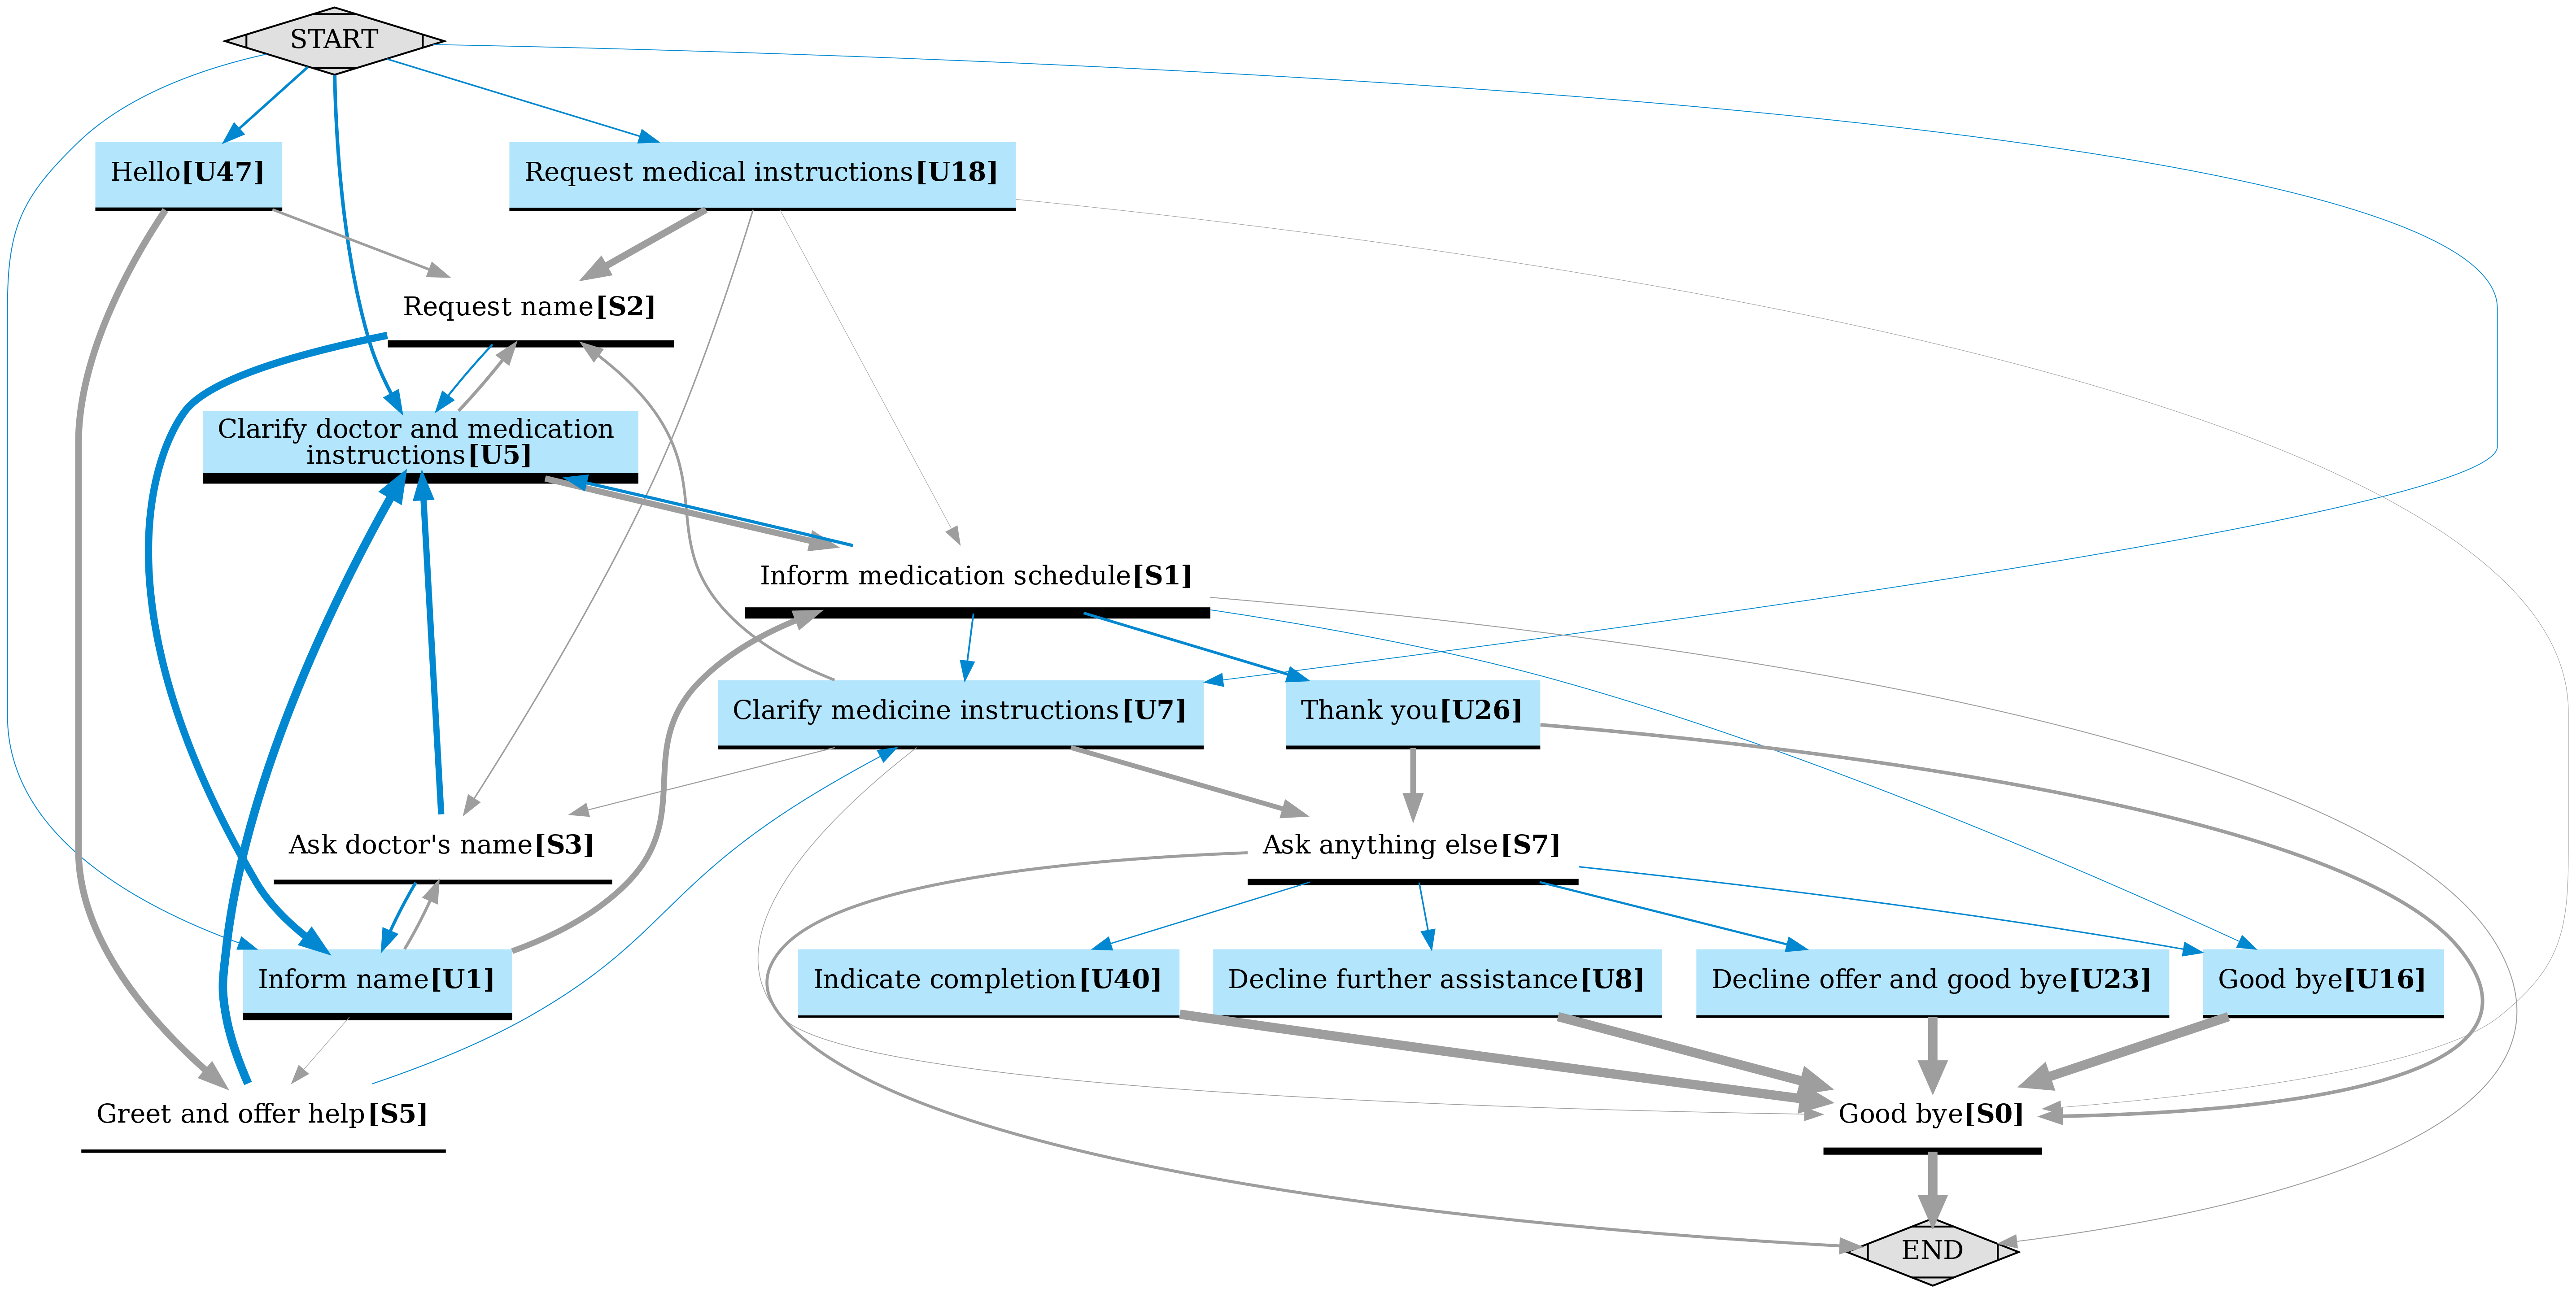

[2025-06-02 14:14:13,337.337]   Finished creating the graph.


In [28]:
from dialog2flow import dialog2graph

graph, nodes = dialog2graph(PATH_OUTPUT)

if colab:
    display(Image.open("output/STAR/original/dialog2flow/graph/dialog2flow-joint-bert-base/graph.png"))

In the above graph, white nodes are System nodes while blue ones are User nodes.

We can see that the "discovered" graph after the analysis essentially shows a similar flow as the one we know was used for the orchestration under the hood, for this task:

In [9]:
print(STAR.read_graph("doctor_followup"))  # System original graph

digraph doctor_followup  {
    hello -> ask_name;
    ask_name -> doctor_ask_doctor_name;
    doctor_ask_doctor_name -> query;
    query -> doctor_inform_doctors_instructions;
    doctor_inform_doctors_instructions -> anything_else
}


However, note that the graph shown in the figure above was built without any annotation or knowledge about the original graph, just from the content of the conversations alone (text) and still managed to reveal an underline flow that matches closely the real one. This implyes that the humans who create the original dialogues were correctly role playing the characters and produced final dialogues matching the expected flow.

Note that the `dialog2graph()` function returned a `graph` and a `nodes` object, the first one is the graph as a [`NetworkX`](https://networkx.org/)'s [`DiGraph`](https://networkx.org/documentation/stable/reference/classes/digraph.html) object:

In [10]:
graph

And the second one, allow us to get the top-k utterances that were used under the hood to create/discover each node.

We can use it to analyse and debug each step by using the provided codes (e.g. `[U8]`) shown at the end of each node name.

For instance, let's see the utterances associated to the "Decline offer and good bye [U23]" step:

In [11]:
nodes["u23"]

{'name': 'Decline offer and good bye',
 'utterances': ['No, thank you. Goodbye.',
  'No, thank you. Goodbye.',
  'No thank you. Bye.',
  'No. Thanks. Have a good day.',
  'No. Thanks. Have a good day.']}

Alternativally, we can perform this analysis using the the interactive HTML visualization by setting the `out_interactive=True` argument:

In [12]:
_, _ = dialog2graph(PATH_OUTPUT, out_interactive=True, out_png=False)

[2025-06-02 13:56:57,077.077] Reading conversations...


Dialogues::   0%|          | 0/106 [00:00<?, ?it/s]

[2025-06-02 13:56:57,146.146] Using model 'sergioburdisso/dialog2flow-joint-bert-base' model to generate the embeddings.
[2025-06-02 13:56:57,151.151] Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-06-02 13:56:58,966.966] Clustering SYSTEM utterances...


Cluster labels (System)::   0%|          | 0/16 [00:00<?, ?it/s]

[2025-06-02 13:56:59,135.135] # clusters: 16
[2025-06-02 13:56:59,137.137] # ground truth labels: None
[2025-06-02 13:56:59,139.139] # Total predictions: 446
[2025-06-02 13:56:59,140.140] Clustering USER utterances...


Cluster labels (User)::   0%|          | 0/55 [00:00<?, ?it/s]

[2025-06-02 13:56:59,424.424] # clusters: 55
[2025-06-02 13:56:59,426.426] # ground truth labels: None
[2025-06-02 13:56:59,426.426] # Total predictions: 448
[2025-06-02 13:56:59,446.446]   Reading trajectories from (output/STAR/original/dialog2flow/trajectories-dialog2flow-joint-bert-base.json)...
[2025-06-02 13:56:59,450.450]     105 trajectories read.
[2025-06-02 13:56:59,452.452]   About to start creating the graph...
[2025-06-02 13:56:59,714.714] Found 6 unique labels with repeated nodes to marge
[2025-06-02 13:56:59,715.715]     > Number of nodes before mergin duplicates: 73
[2025-06-02 13:56:59,716.716]     > Number of nodes after mergin duplicates: 64
[2025-06-02 13:56:59,718.718]   #Nodes before pruning: 64
[2025-06-02 13:56:59,720.720]     Widest path: ['User: Clarify doctor and medication instructions', 'Agent: Inform medication schedule', 'User: Thank you', 'Agent: Good bye']
[2025-06-02 13:56:59,722.722]   #Nodes after pruning: 18
[2025-06-02 13:56:59,725.725]   Saving gra

So now you can download the [`output/STAR/original/dialog2flow/graph/dialog2flow-joint-bert-base/visualization/`](output/STAR/original/dialog2flow/graph/dialog2flow-joint-bert-base/visualization/) folder and open the `graph.html` file in it to access the interactive visualization, when hover on nodes you'll see the utterances associated with them.

### Single LLM Full Dialog Generation

[2025-06-02 13:57:02,160.160] Reading conversations...


Dialogues::   0%|          | 0/106 [00:00<?, ?it/s]

[2025-06-02 13:57:03,942.942] Using model 'sergioburdisso/dialog2flow-joint-bert-base' model to generate the embeddings.
[2025-06-02 13:57:03,949.949] Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

[2025-06-02 13:57:05,758.758] Clustering SYSTEM utterances...


Cluster labels (System)::   0%|          | 0/10 [00:00<?, ?it/s]

[2025-06-02 13:57:06,134.134] # clusters: 10
[2025-06-02 13:57:06,135.135] # ground truth labels: None
[2025-06-02 13:57:06,136.136] # Total predictions: 565
[2025-06-02 13:57:06,137.137] Clustering USER utterances...


Cluster labels (User)::   0%|          | 0/11 [00:00<?, ?it/s]

[2025-06-02 13:57:06,627.627] # clusters: 11
[2025-06-02 13:57:06,629.629] # ground truth labels: None
[2025-06-02 13:57:06,630.630] # Total predictions: 458
[2025-06-02 13:57:06,642.642]   Reading trajectories from (output/STAR/full-generation/txt/dialog2flow/trajectories-dialog2flow-joint-bert-base.json)...
[2025-06-02 13:57:06,647.647]     105 trajectories read.
[2025-06-02 13:57:06,648.648]   About to start creating the graph...
[2025-06-02 13:57:06,664.664] Found 2 unique labels with repeated nodes to marge
[2025-06-02 13:57:06,665.665]     > Number of nodes before mergin duplicates: 23
[2025-06-02 13:57:06,666.666]     > Number of nodes after mergin duplicates: 20
[2025-06-02 13:57:06,668.668]   #Nodes before pruning: 20
[2025-06-02 13:57:06,688.688]     Widest path: ['Agent: Greet and offer help', "User: Confirm doctor's instructions", 'Agent: Provide medical instructions and schedule follow-up', 'User: Thank you and ask anything else', 'Agent: Ask anything else', 'User: Good by

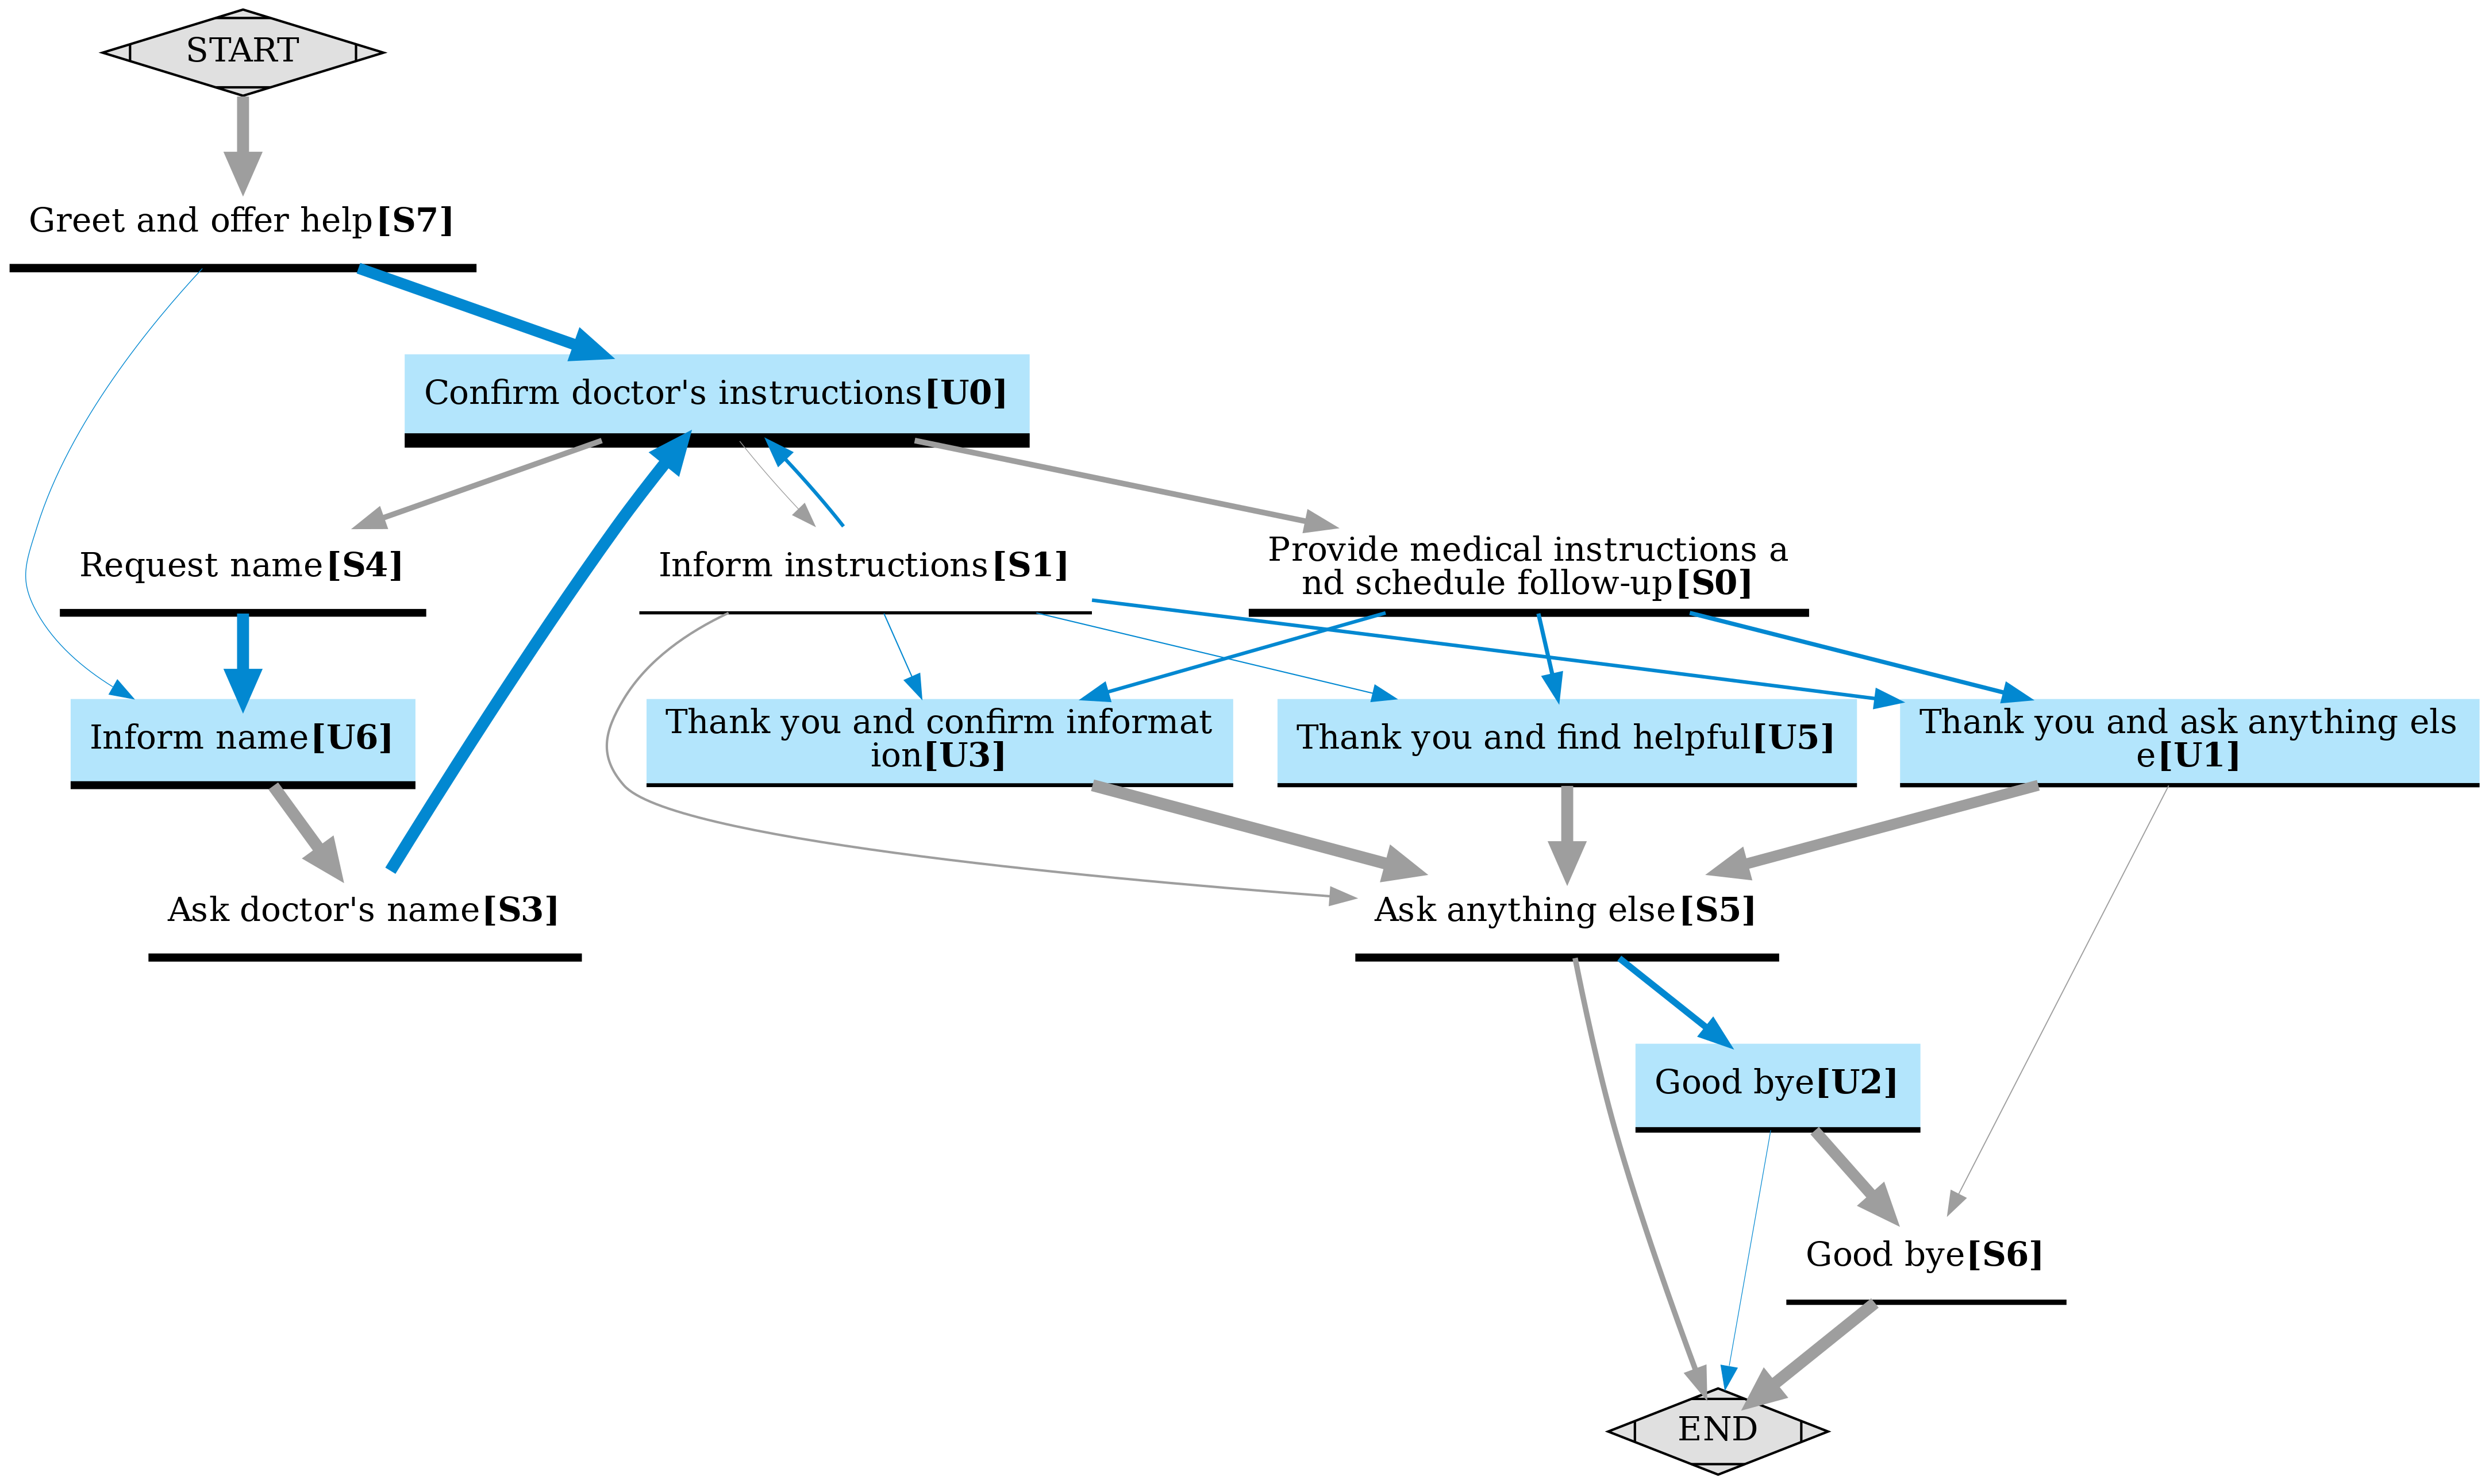

[2025-06-02 13:57:07,658.658]   Finished creating the graph.


In [13]:
_, nodes = dialog2graph("output/STAR/full-generation/txt")

if colab:
    display(Image.open("output/STAR/full-generation/txt/dialog2flow/graph/dialog2flow-joint-bert-base/graph.png"))

The graph looks quite good, and resambles a similar flow as the original one.

However, why do we have seemly duplicated _"Provide medical instructions [S0]"_ and _"Inform instructions [S1]"_ nodes? let's see what are the utterances used for their labels:

In [14]:
nodes["s0"]

{'name': 'Provide medical instructions and schedule follow-up',
 'utterances': ['Your instructions are: Take the prescribed medication twice daily with meals and schedule another appointment in two months. Also, monitor your blood pressure daily and report any unusual symptoms to our clinic immediately.',
  'Your instructions are: Take the prescribed medication twice a day, maintain a healthy diet and regular exercise routine, and schedule a follow-up appointment in six weeks.',
  'Your instructions are: Take the prescribed medication twice a day, monitor your blood pressure daily and schedule another appointment in two weeks for a follow-up.',
  'Your instructions are: Take the prescribed medication twice daily for two weeks, drink plenty of water and return to the office in four weeks for a follow-up visit.',
  'Your instructions are: Take the prescribed medication twice a day, and follow up with an appointment in two weeks to review progress.']}

In [15]:
nodes["s1"]

{'name': 'Inform instructions',
 'utterances': ['Your instructions are: INSTRUCTIONS.',
  'Your instructions are: INSTRUCTIONS.',
  'Your instructions are: INSTRUCTIONS.',
  'Your instructions are: INSTRUCTIONS.',
  'Your instructions are: INSTRUCTIONS.']}

So it seems the LLM had issues when generating the System turn that inform the instructions in some cases, since in the "Inform instructions [S1]" node we can see there are dialogs in which the instructions were given literally as a template!

And what about the user step "Thank you and ask anything else", the user is not suppose to ask for anything else, but the system. Let's check the node:

In [16]:
nodes["u1"]

{'name': 'Thank you and ask anything else',
 'utterances': ['Thank you. Is there anything else I should know?',
  'Thank you. Is there anything else I should know?',
  'Thank you. Is there anything else I should know?',
  'Thank you! Is there anything else I need to know?',
  'Thank you! Is there anything else I need to know?']}

Ok, "anything else" in the name was referring to _anything else the user should know_, which is fine.

### Role-Play Multi-Agent-based Generation

[2025-06-02 14:35:00,534.534] Reading conversations...


Dialogues::   0%|          | 0/106 [00:00<?, ?it/s]

[2025-06-02 14:35:00,628.628] Using model 'sergioburdisso/dialog2flow-joint-bert-base' model to generate the embeddings.
[2025-06-02 14:35:00,637.637] Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

[2025-06-02 14:35:02,804.804] Clustering SYSTEM utterances...


Cluster labels (System)::   0%|          | 0/9 [00:00<?, ?it/s]

[2025-06-02 14:35:03,004.004] # clusters: 9
[2025-06-02 14:35:03,005.005] # ground truth labels: None
[2025-06-02 14:35:03,006.006] # Total predictions: 575
[2025-06-02 14:35:03,007.007] Clustering USER utterances...


Cluster labels (User)::   0%|          | 0/15 [00:00<?, ?it/s]

[2025-06-02 14:35:03,199.199] # clusters: 15
[2025-06-02 14:35:03,200.200] # ground truth labels: None
[2025-06-02 14:35:03,201.201] # Total predictions: 470
[2025-06-02 14:35:03,215.215]   Reading trajectories from (output/STAR/multi-agents/txt/dialog2flow/trajectories-dialog2flow-joint-bert-base.json)...
[2025-06-02 14:35:03,221.221]     105 trajectories read.
[2025-06-02 14:35:03,222.222]   About to start creating the graph...
[2025-06-02 14:35:03,226.226] Found 2 unique labels with repeated nodes to marge
[2025-06-02 14:35:03,227.227]     > Number of nodes before mergin duplicates: 26
[2025-06-02 14:35:03,229.229]     > Number of nodes after mergin duplicates: 24
[2025-06-02 14:35:03,230.230]   #Nodes before pruning: 24
[2025-06-02 14:35:03,232.232]     Widest path: ['Agent: Greet and offer help', 'User: Request clarification on medication instructions from doctor', 'Agent: Provide medical instructions and ask if anything else is needed', 'User: Thank you and good bye', 'Agent: Goo

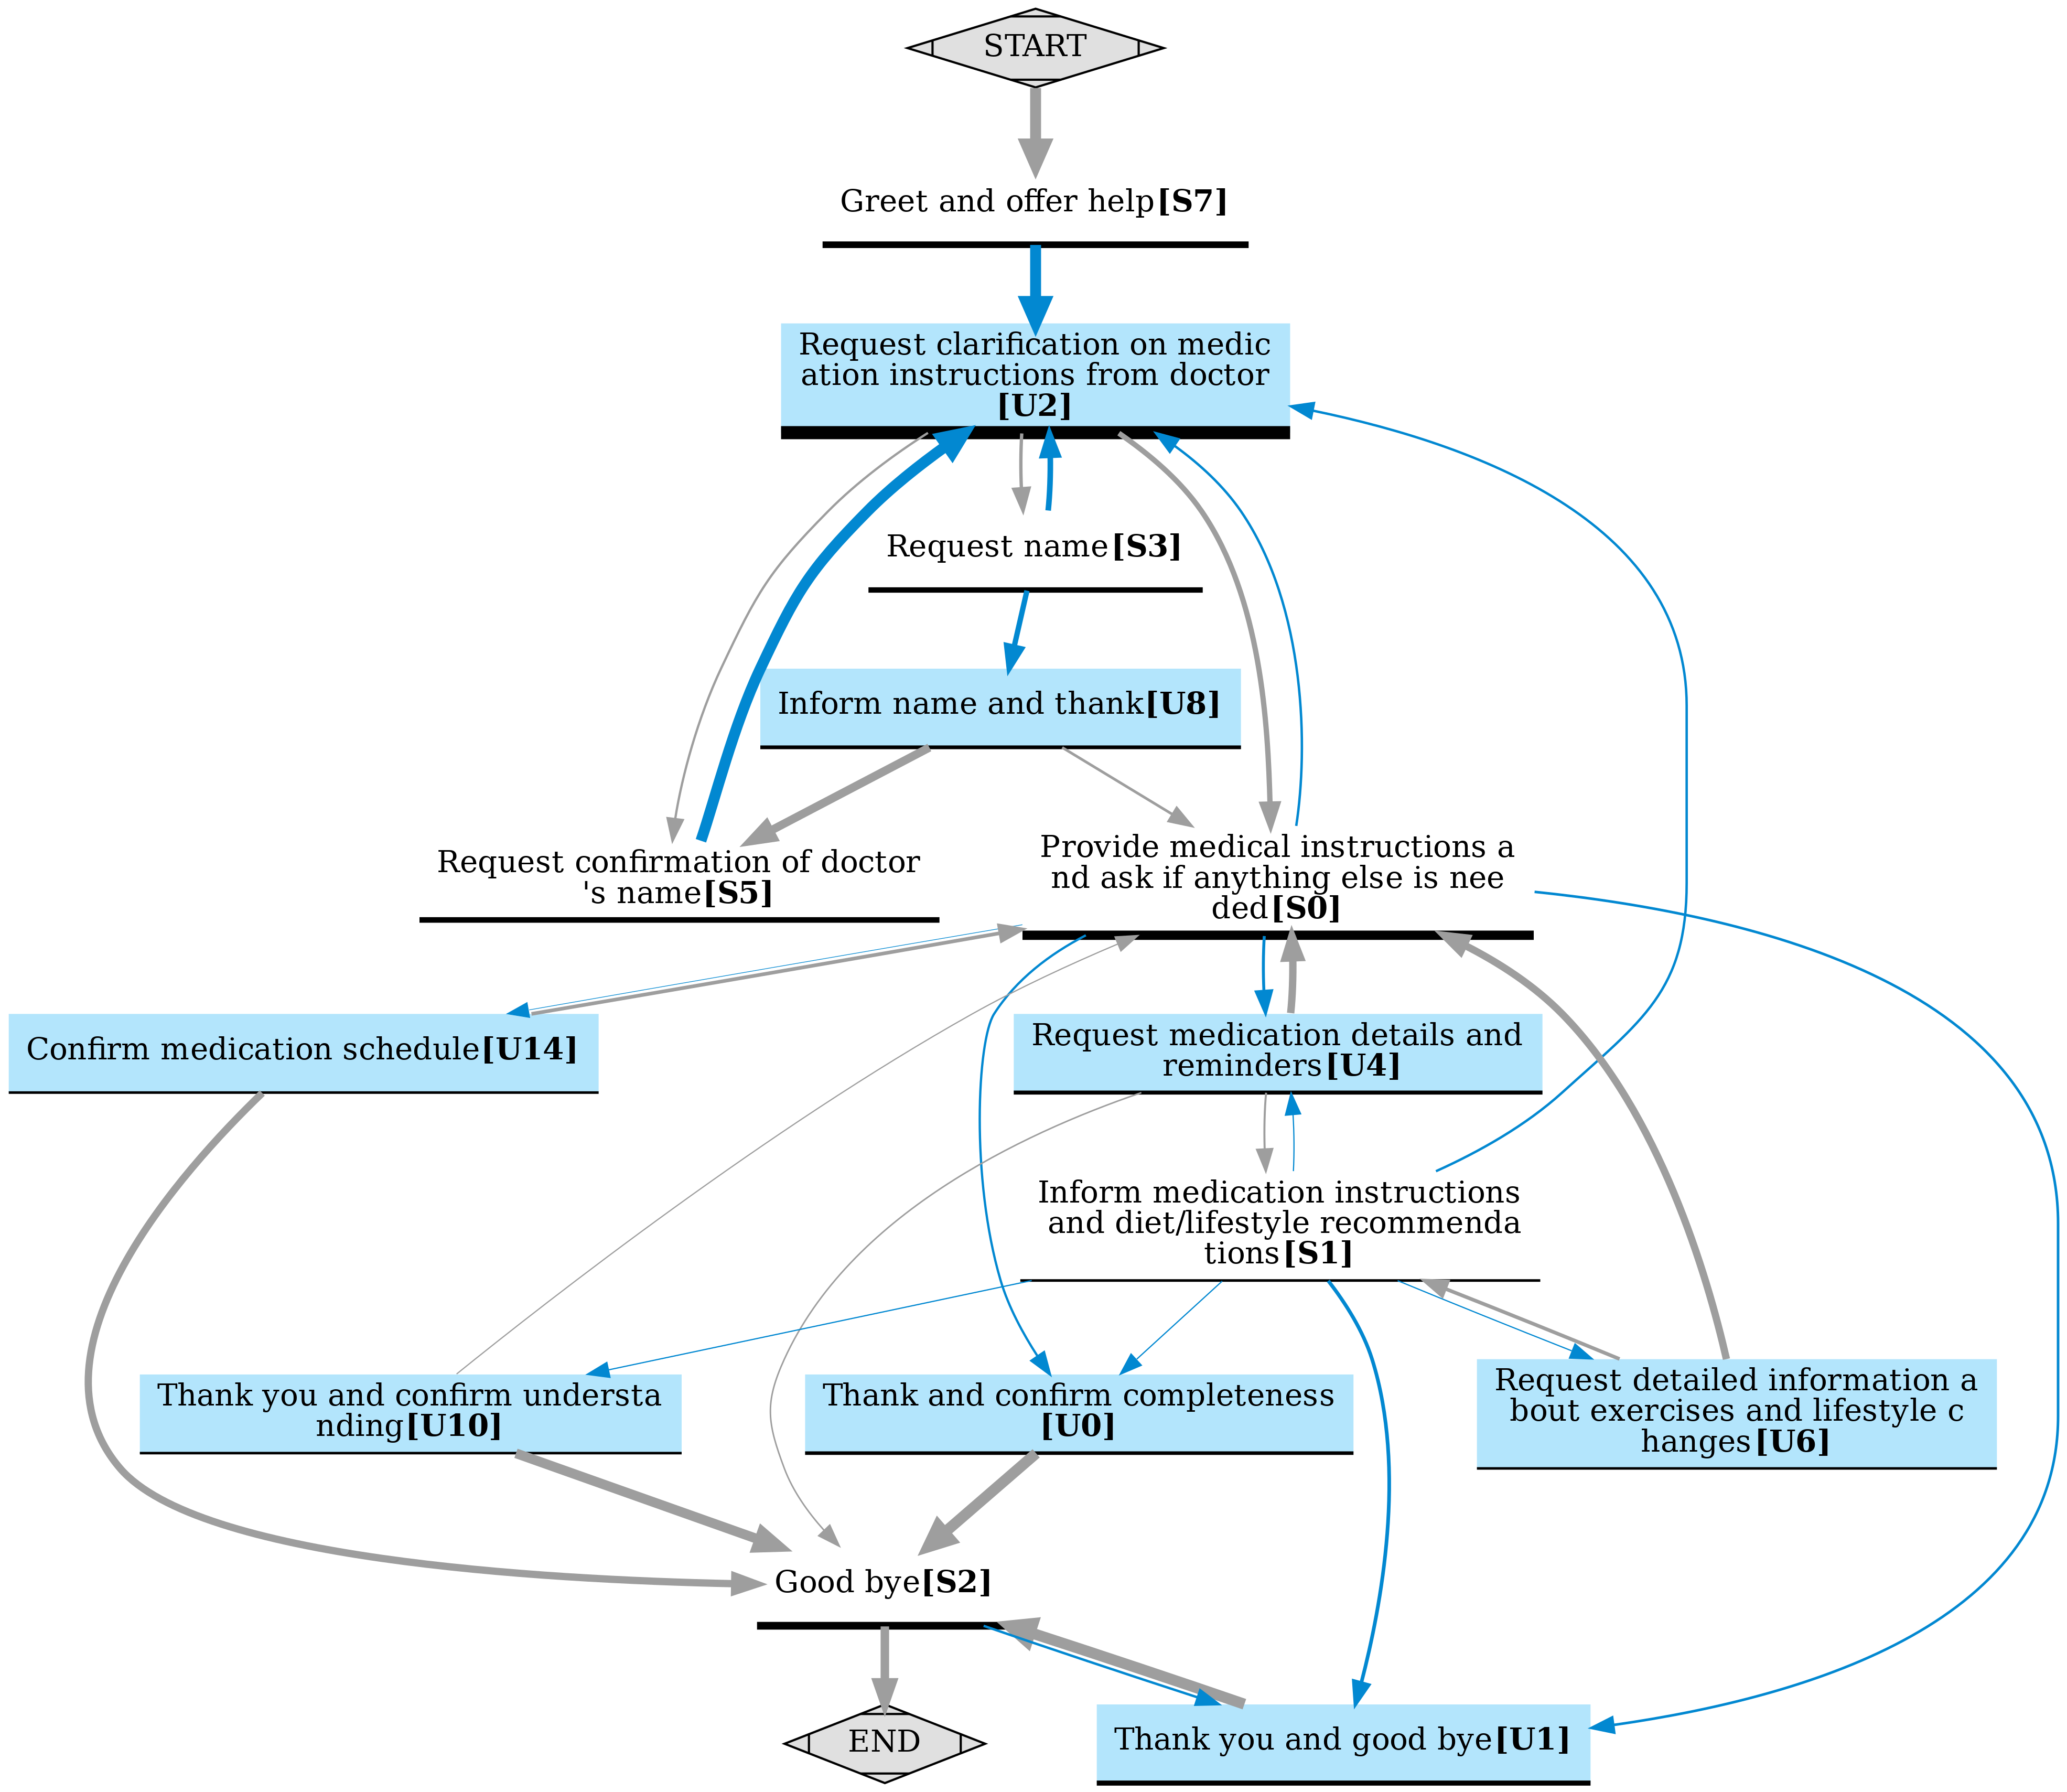

[2025-06-02 14:35:04,819.819]   Finished creating the graph.


In [40]:
from dialog2flow import dialog2graph

_, nodes = dialog2graph("output/STAR/multi-agents/txt", node_thresholds=.45)

if colab:
    display(Image.open("output/STAR/multi-agents/txt/dialog2flow/graph/dialog2flow-joint-bert-base/graph.png"))

We can see this graph is a little bit more complex than the ones before, with more user steps and some steps involving multiple actions.

For instance, there's no single step for system asking for the doctor's name, but rather a `"Request confirmation of doctor's name [S5]"` because the user normally inform the doctor name while requesting for medication clarification (i.e. `"Request clarification on medication instructions FROM DOCTOR [U2]"`). Let's check these nodes:

In [49]:
nodes["u2"]

{'name': 'Request clarification on medication instructions from doctor',
 'utterances': ['Hi! I just had my appointment with Dr. Alexis but forgot to write down her instructions. Could you please tell me how often I should take my medication?',
  'Hi! I was wondering if Dr. Johnson is available for a quick follow-up call? We had an appointment last week and I want to make sure I understood everything correctly regarding my medication regimen.',
  'Hi, this is Angela. I had an appointment with Dr. Johnson last week and I wanted to make sure I understood everything correctly regarding my treatment plan. Could you please help me review it?',
  'Yes, it’s Dr. Morgan. I had an appointment with her recently and she gave me some medication, but I forgot to write down how often I should take it. Could you help me with that, please?',
  'Hi, this is Ben. I had an appointment with Dr. Morgan last week and I want to make sure I understood everything correctly regarding my treatment plan. Could we

In [51]:
nodes["s5"]

{'name': "Request confirmation of doctor's name",
 'utterances': ['Who is your doctor, Mark? Just to confirm, is it Dr. Alexis?',
  "Who is your doctor, Mark? Just confirming it's Dr. Johnson we're discussing.",
  'Who is your doctor, Mark? Just to confirm, is it Dr. Johnson?',
  'Who is your doctor, John? Just to confirm, is it Dr. Alexis?',
  'Who is your doctor, John? Just to confirm, is it Dr. Alexis?']}

In addition, we can also see that this graph contains new user steps, for instance, after the system `"provide medical instructions and ask if anything else is needed [S0]"` now the user asked for more details like `"Request medication details and reminders [U4]"` or `"Request detailed information about exercises and lifestyle changes"`, let's check them:

In [44]:
nodes["u4"]

{'name': 'Request medication details and reminders',
 'utterances': ['Thanks for summarizing that. Could you remind me again of the specific dosage instructions for my medication and when I should take them? Also, are there any signs or symptoms I should be particularly aware of before my follow-up appointment in two weeks?',
  "Thanks for the details on the side effects and reassurance that no additional tests are needed right now. Could you also remind me of the dosage and timing for each medication? I want to make sure I'm taking them correctly.",
  'Thanks for summarizing that. Could we also review the side effects I should be aware of for my current medications? And maybe go over what to expect at the next appointment?',
  'Thanks for summarizing that. Could you remind me of the specific side effects I should be aware of while taking this new medication? And how often should I check my blood pressure at home?',
  "That's perfect, thank you! Could you remind me of the dosage for ea

In [45]:
nodes["u6"]

{'name': 'Request detailed information about exercises and lifestyle changes',
 'utterances': ['Thanks for that information! What about the strength training exercises—could we go over those in more detail as well? Are there specific types of equipment Dr. Morgan recommends, or can I use bodyweight exercises at home?',
  'Thanks for summarizing that. Could we go over the specific types of exercises Dr. Morgan recommended? I want to make sure I’m doing them correctly and safely.',
  'That’s really helpful. Could you also remind me of any lifestyle changes that might support my recovery besides diet and exercise? And do you have any tips for managing stress during this period? Thank you so much!',
  "That's very helpful. Could you also remind me of any lifestyle changes Dr. Alexis suggested along with the treatment plan?",
  'That’s very helpful! Could we discuss the types of aerobic activities in more detail? Are there any particular times of day that are better for these workouts, or i

This behavior is not necessarily a bad thing per se, in case we don't want such "more complex" behavior, now that we know that it exists, we could set special instructions to force the agents to associate one action per utterance only, and to not ask for more details about the given instructions. This changes may make sound more "robotic", less natural, though, as in the original conversations where humans where instructed to "stick to their scripts" though the orchestration. Let's check what happed with this multi-agent dialogues when we added orchestration too.

### Role-Play Multi-Agent-based Generation with Orchestration

[2025-06-02 15:01:55,584.584] Reading conversations...


Dialogues::   0%|          | 0/106 [00:00<?, ?it/s]

[2025-06-02 15:01:55,659.659] Using model 'sergioburdisso/dialog2flow-joint-bert-base' model to generate the embeddings.
[2025-06-02 15:01:55,664.664] Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

[2025-06-02 15:01:58,023.023] Clustering SYSTEM utterances...


Cluster labels (System)::   0%|          | 0/10 [00:00<?, ?it/s]

[2025-06-02 15:01:58,198.198] # clusters: 10
[2025-06-02 15:01:58,199.199] # ground truth labels: None
[2025-06-02 15:01:58,200.200] # Total predictions: 524
[2025-06-02 15:01:58,201.201] Clustering USER utterances...


Cluster labels (User)::   0%|          | 0/12 [00:00<?, ?it/s]

[2025-06-02 15:01:58,351.351] # clusters: 12
[2025-06-02 15:01:58,352.352] # ground truth labels: None
[2025-06-02 15:01:58,353.353] # Total predictions: 419
[2025-06-02 15:01:58,366.366]   Reading trajectories from (output/STAR/multi-agents+orchestration/txt/dialog2flow/trajectories-dialog2flow-joint-bert-base.json)...
[2025-06-02 15:01:58,371.371]     105 trajectories read.
[2025-06-02 15:01:58,372.372]   About to start creating the graph...
[2025-06-02 15:01:58,377.377] Found 1 unique labels with repeated nodes to marge
[2025-06-02 15:01:58,378.378]     > Number of nodes before mergin duplicates: 24
[2025-06-02 15:01:58,379.379]     > Number of nodes after mergin duplicates: 23
[2025-06-02 15:01:58,380.380]   #Nodes before pruning: 23
[2025-06-02 15:01:58,381.381]     Widest path: ['Agent: Greet and offer help', 'User: Inform name and request review of medical discussion', 'Agent: Provide medical instructions and ask if anything else is needed']
[2025-06-02 15:01:58,383.383]   #Node

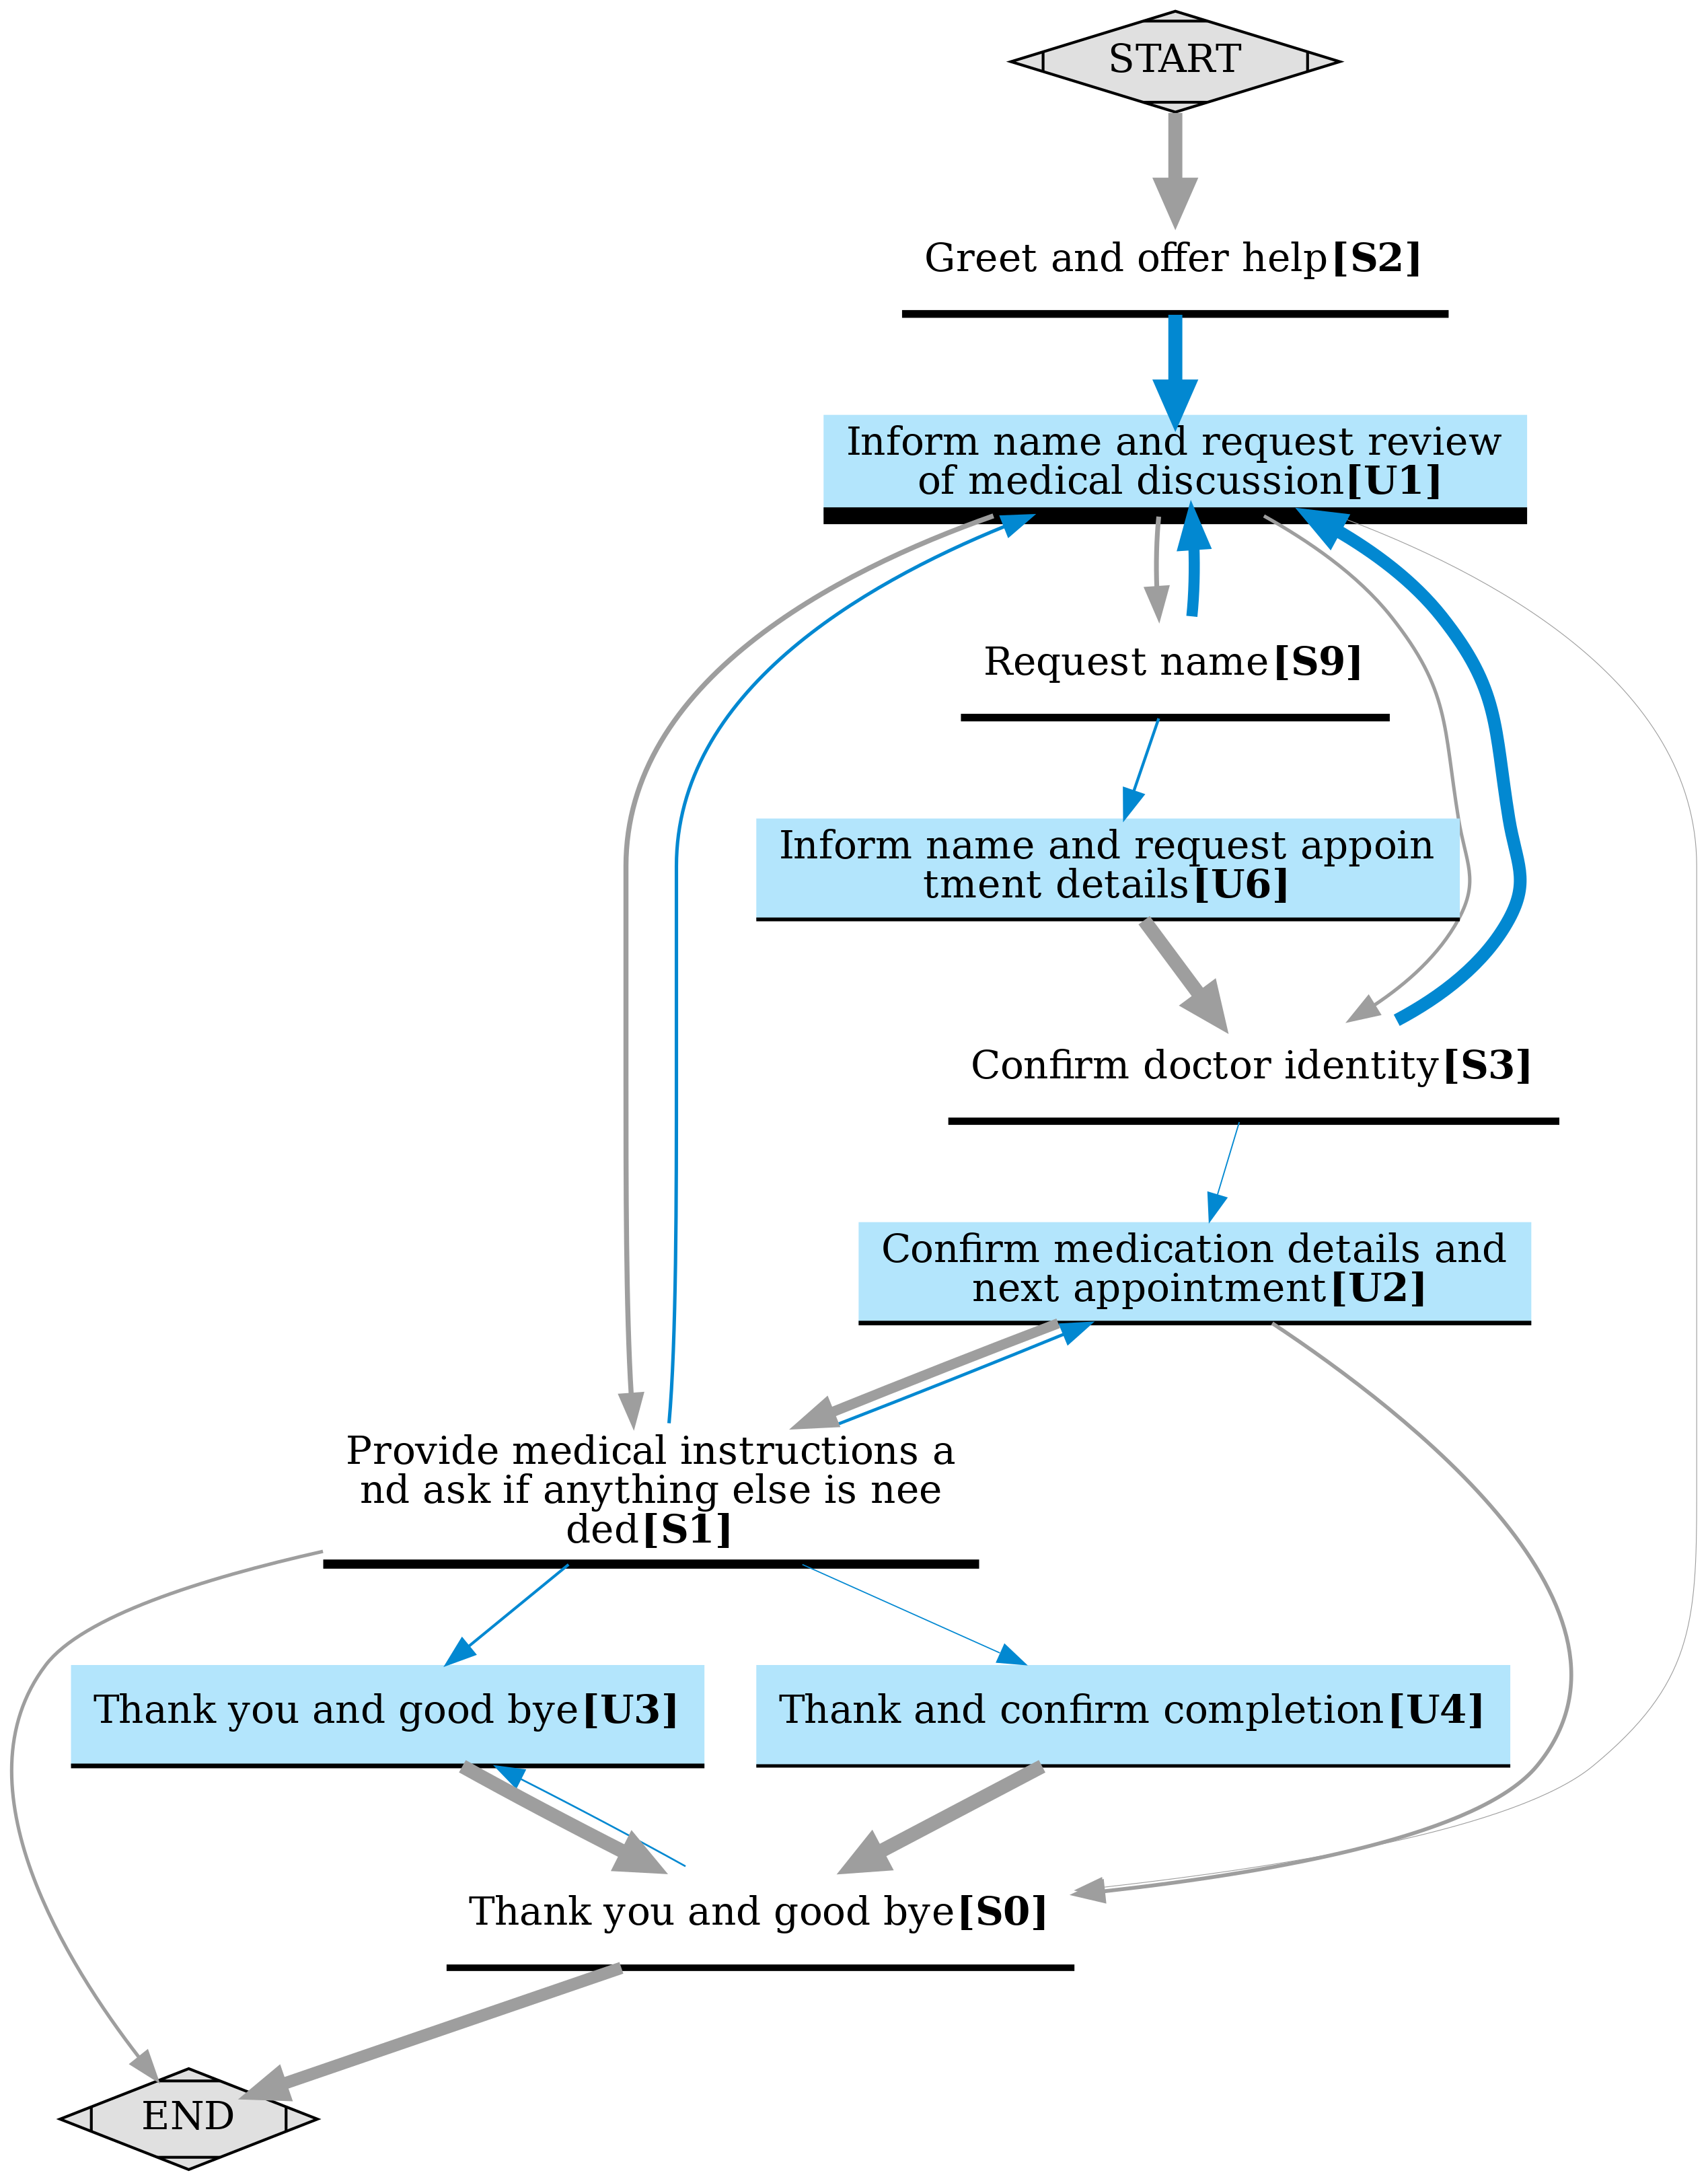

[2025-06-02 15:01:59,331.331]   Finished creating the graph.


In [53]:
PATH_ORCHESTRATION_DIALOGUES = "output/STAR/multi-agents+orchestration/txt"

_, nodes = dialog2graph(PATH_ORCHESTRATION_DIALOGUES, node_thresholds=.45)

if colab:
    display(Image.open("output/STAR/multi-agents+orchestration/txt/dialog2flow/graph/dialog2flow-joint-bert-base/graph.png"))

We can see this graph is more similar to the original one, where each node correspond to single actions and where there is no further details asked after the system `"Provide medical instructions and ask if anything else is needed [S1]"` :)

#### Extra details about `node_thresholds=0.45`

When calling `dialog2graph()` above, where did that `node_thresholds=.45` come from? this argument allow us to control the level of details of the graph.

More precisely, under the hood, it is the distance value for the agglomerative clustering algorithm to cluster utterances as different steps, therefore:

* The smaller the value, the smaller (more similar) the clusters, and the greater the number of discovered "steps" (nodes in the graph).
* That is, the smaller the `node_thresholds`, the more details represented in the final graph.

We can use the `dialog2trajectories` function to try to find a good threshold value, visually, using a dendrogram plot as follow:

[2025-06-02 14:15:10,956.956] Reading conversations...


Dialogues::   0%|          | 0/106 [00:00<?, ?it/s]

[2025-06-02 14:15:11,020.020] Using model 'sergioburdisso/dialog2flow-joint-bert-base' model to generate the embeddings.
[2025-06-02 14:15:11,025.025] Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

[2025-06-02 14:15:13,288.288] Clustering SYSTEM utterances...
[2025-06-02 14:15:13,417.417] # clusters: 4
[2025-06-02 14:15:13,419.419] # ground truth labels: None
[2025-06-02 14:15:13,420.420] # Total predictions: 524


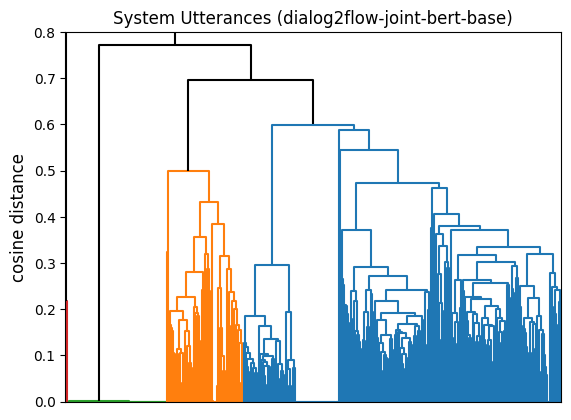

[2025-06-02 14:15:13,910.910] Dendrogram plot for system utterances saved in `output/STAR/multi-agents+orchestration/txt/dialog2flow/plots/dendrogram_dialog2flow-joint-bert-base.system.png`
[2025-06-02 14:15:13,911.911] Clustering USER utterances...
[2025-06-02 14:15:14,007.007] # clusters: 3
[2025-06-02 14:15:14,008.008] # ground truth labels: None
[2025-06-02 14:15:14,009.009] # Total predictions: 419


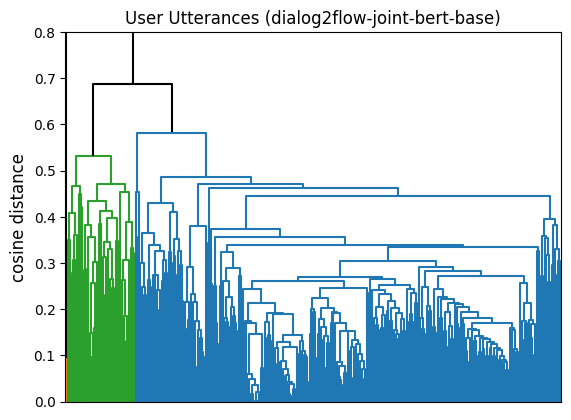

[2025-06-02 14:15:14,303.303] Dendrogram plot for user utterances saved in `output/STAR/multi-agents+orchestration/txt/dialog2flow/plots/dendrogram_dialog2flow-joint-bert-base.user.png`


'output/STAR/multi-agents+orchestration/txt/dialog2flow/trajectories-dialog2flow-joint-bert-base.json'

In [29]:
from dialog2flow import dialog2trajectories

dialog2trajectories(PATH_ORCHESTRATION_DIALOGUES)

We can clearly see that we need to decrease the threshold value since we have a very large (blue) cluster in both plots. This large blue cluster is clearly merging too many sub groups.

In fact, from the above plots we can see that a good value should be between 0.3 and 0.5, let's say we decide to use 0.45:

[2025-06-02 15:43:27,491.491] Reading conversations...


Dialogues::   0%|          | 0/106 [00:00<?, ?it/s]

[2025-06-02 15:43:27,566.566] Using model 'sergioburdisso/dialog2flow-joint-bert-base' model to generate the embeddings.
[2025-06-02 15:43:27,571.571] Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

[2025-06-02 15:43:29,826.826] Clustering SYSTEM utterances...
[2025-06-02 15:43:29,963.963] # clusters: 10
[2025-06-02 15:43:29,964.964] # ground truth labels: None
[2025-06-02 15:43:29,965.965] # Total predictions: 524


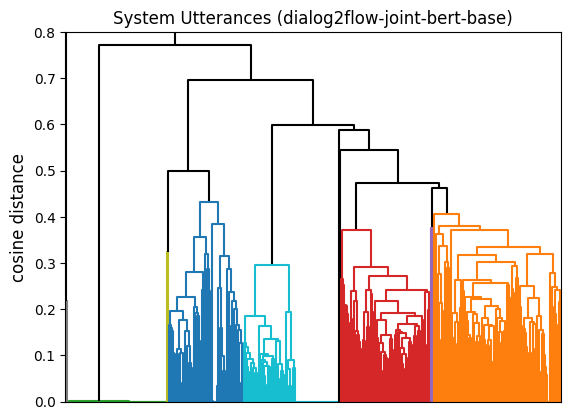

[2025-06-02 15:43:30,273.273] Dendrogram plot for system utterances saved in `output/STAR/multi-agents+orchestration/txt/dialog2flow/plots/dendrogram_dialog2flow-joint-bert-base.system.png`
[2025-06-02 15:43:30,274.274] Clustering USER utterances...
[2025-06-02 15:43:30,383.383] # clusters: 12
[2025-06-02 15:43:30,384.384] # ground truth labels: None
[2025-06-02 15:43:30,385.385] # Total predictions: 419


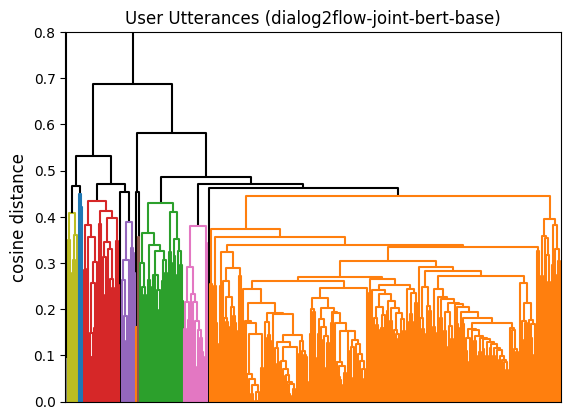

[2025-06-02 15:43:30,683.683] Dendrogram plot for user utterances saved in `output/STAR/multi-agents+orchestration/txt/dialog2flow/plots/dendrogram_dialog2flow-joint-bert-base.user.png`


'output/STAR/multi-agents+orchestration/txt/dialog2flow/trajectories-dialog2flow-joint-bert-base.json'

In [55]:
dialog2trajectories(PATH_ORCHESTRATION_DIALOGUES, thresholds=0.45)

That looks much better! :)

What happend now if we think that the threshold should be different between the user and the system? in fact, `dialog2trajectories()` can take two threshold values to control each.

In our example, we know system interactions should be simpler than user so make sense to use a "more abstract"/simpler steps to analyse the system than the user. Furthermore, let's say we believe/think to know the exact or a good number of actions to be discovered, we can pass to `dialog2flow()` or `dialog2trajectories()` directly the number of actions/steps too, instead of the threshold.

For instance, let's say that, based on the first plot, we think 10 clusters is good for the system, and a threshold of 0.3 for user is also good, then we can specify this as follows:

[2025-06-02 15:46:58,205.205] Reading conversations...


Dialogues::   0%|          | 0/106 [00:00<?, ?it/s]

[2025-06-02 15:46:58,289.289] Using model 'sergioburdisso/dialog2flow-joint-bert-base' model to generate the embeddings.
[2025-06-02 15:46:58,294.294] Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

[2025-06-02 15:47:00,679.679] Clustering SYSTEM utterances...
[2025-06-02 15:47:00,822.822] # clusters: 10
[2025-06-02 15:47:00,824.824] # ground truth labels: None
[2025-06-02 15:47:00,825.825] # Total predictions: 524


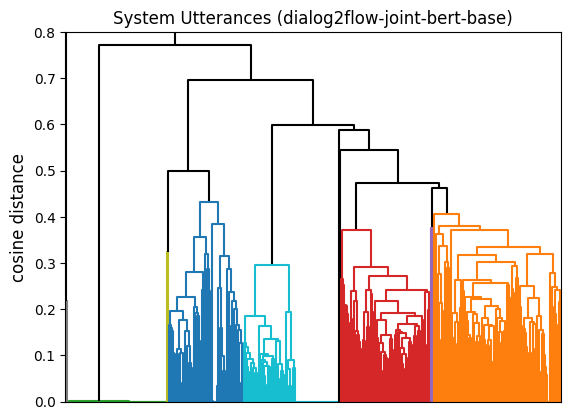

[2025-06-02 15:47:01,143.143] Dendrogram plot for system utterances saved in `output/STAR/multi-agents+orchestration/txt/dialog2flow/plots/dendrogram_dialog2flow-joint-bert-base.system.png`
[2025-06-02 15:47:01,144.144] Clustering USER utterances...
[2025-06-02 15:47:01,354.354] # clusters: 64
[2025-06-02 15:47:01,355.355] # ground truth labels: None
[2025-06-02 15:47:01,357.357] # Total predictions: 419


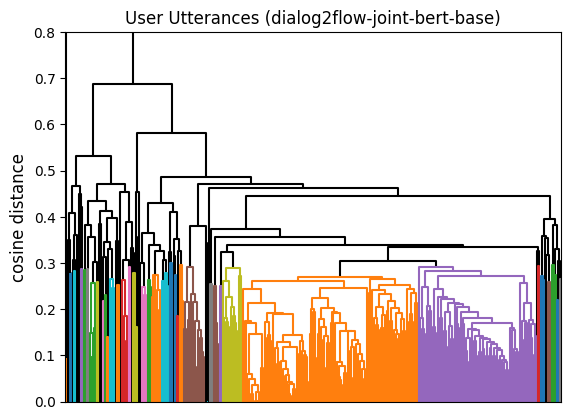

[2025-06-02 15:47:01,690.690] Dendrogram plot for user utterances saved in `output/STAR/multi-agents+orchestration/txt/dialog2flow/plots/dendrogram_dialog2flow-joint-bert-base.user.png`


'output/STAR/multi-agents+orchestration/txt/dialog2flow/trajectories-dialog2flow-joint-bert-base.json'

In [56]:
dialog2trajectories(PATH_ORCHESTRATION_DIALOGUES, thresholds=[10, 0.3])

Finally, once we find the right threshold values for right level of abstraction that is required by our analysis, then we can pass them to our `dialog2graph()` function using the `node_thresholds` argument:

[2025-06-02 15:47:55,825.825] Reading conversations...


Dialogues::   0%|          | 0/106 [00:00<?, ?it/s]

[2025-06-02 15:47:55,911.911] Using model 'sergioburdisso/dialog2flow-joint-bert-base' model to generate the embeddings.
[2025-06-02 15:47:55,921.921] Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

[2025-06-02 15:47:58,128.128] Clustering SYSTEM utterances...


Cluster labels (System)::   0%|          | 0/10 [00:00<?, ?it/s]

[2025-06-02 15:47:58,303.303] # clusters: 10
[2025-06-02 15:47:58,304.304] # ground truth labels: None
[2025-06-02 15:47:58,305.305] # Total predictions: 524
[2025-06-02 15:47:58,306.306] Clustering USER utterances...


Cluster labels (User)::   0%|          | 0/64 [00:00<?, ?it/s]

[2025-06-02 15:47:58,666.666] # clusters: 64
[2025-06-02 15:47:58,667.667] # ground truth labels: None
[2025-06-02 15:47:58,668.668] # Total predictions: 419
[2025-06-02 15:47:58,682.682]   Reading trajectories from (output/STAR/multi-agents+orchestration/txt/dialog2flow/trajectories-dialog2flow-joint-bert-base.json)...
[2025-06-02 15:47:58,688.688]     105 trajectories read.
[2025-06-02 15:47:58,689.689]   About to start creating the graph...
[2025-06-02 15:47:58,694.694] Found 3 unique labels with repeated nodes to marge
[2025-06-02 15:47:58,695.695]     > Number of nodes before mergin duplicates: 76
[2025-06-02 15:47:58,696.696]     > Number of nodes after mergin duplicates: 55
[2025-06-02 15:47:58,697.697]   #Nodes before pruning: 55
[2025-06-02 15:47:58,699.699]     Widest path: ['Agent: Greet and offer help', "User: Confirm understanding of medication from doctor's appointment", 'Agent: Provide medical instructions and ask if anything else is needed']
[2025-06-02 15:47:58,701.701

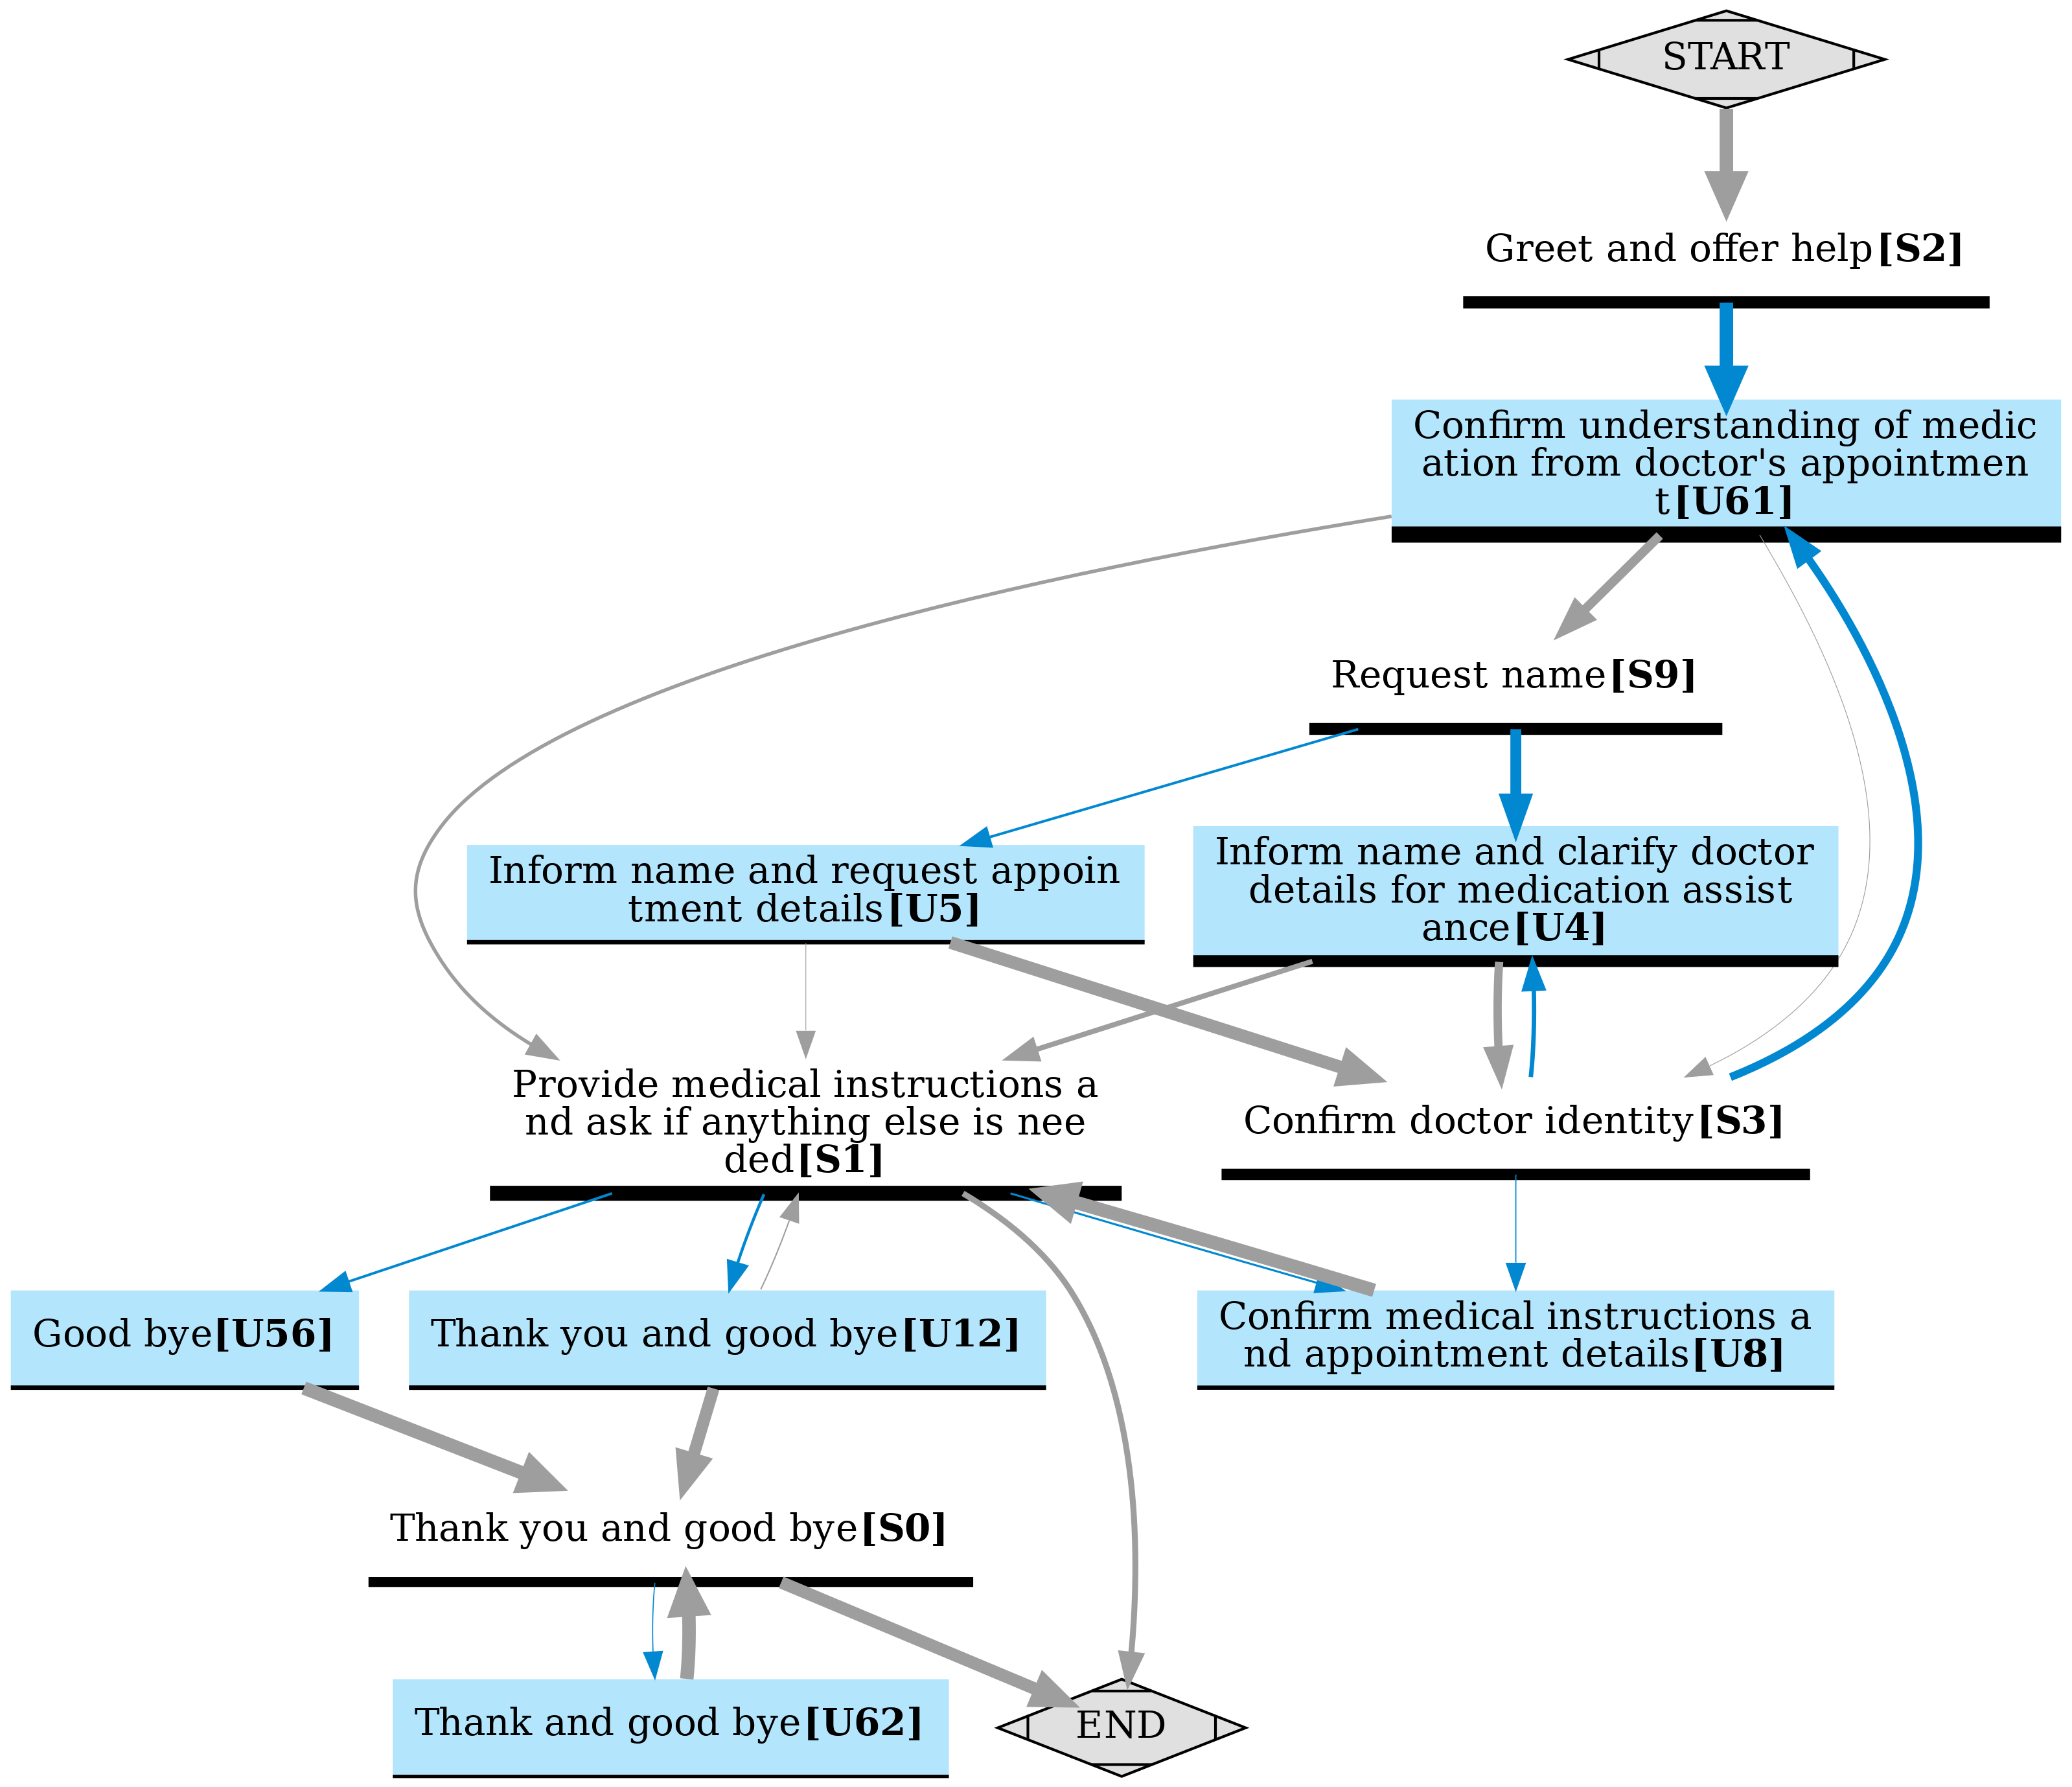

[2025-06-02 15:47:59,731.731]   Finished creating the graph.


In [57]:
_, _ = dialog2graph(PATH_ORCHESTRATION_DIALOGUES, node_thresholds=[10, 0.3])

if colab:
    display(Image.open("output/STAR/multi-agents+orchestration/txt/dialog2flow/graph/dialog2flow-joint-bert-base/graph.png"))

And that's it! you have reached the end of our series of tutorials. Well done! 💪😎 Take a cup of coffee, ☕ well deserved!